## GRU model testing
OK, we have done carry forward control, we have done simple linear models, we have done ARIMA - last thing to try before going on a data hunt in true neural network based models. We could try some regression with vanilla dense layers or something, but I think we should cut to the chase and go straight to a GRU based network. Let's get a minimal example set up to get an idea of what we are working with and then set up a more rigorous hyperparameter optimization with crossvalidation/bootstrapping.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda/'

import shelve
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

# Add notebook parent dir to path so we can import from functions/
import sys
sys.path.append('..')

# Import project config file
import config as conf

# Import notebooks specific helper functions
import functions.notebook_helper_functions.notebook15 as funcs
import functions.initialization_functions as init_funcs

# Instantiate paths and model parameters
paths = conf.DataFilePaths()
params = conf.GRU_model_parameters()

# Load data column index
index = shelve.open(paths.PARSED_DATA_COLUMN_INDEX)

# Fire up logger
logger = init_funcs.start_logger(
    logfile = f'{paths.LOG_DIR}/{params.log_file_name}',
    logstart_msg = 'Starting GRU hyperparameter optimization run'
)

OK, so here we go. Hardest part about working with this type of model is getting the data into the correct shape for input. Couple of considerations here:
1. Do training/validation split where data is kept in sequential time order with older data being used for training and newer data being used for validation.
2. Start with only one input feature - the microbusiness density (or detrended microbusiness density).
3. Forecast one point into the future.
4. Be ready to standardize/unstandardize data using statistics from the training set only.
5. Input data is formatted as (batch, timesteps, feature). 

The last part is a little complicated to think about - we have > 3k timeseries with the same time axis, one for each county. We could treat this like 3k features, but I think the better idea is to think of it as one feature and 3k counties * 37 timepoints input datapoints. The trick is, how do we batch/make timesteps out of it? We don't want to present the model timeseries from different counties as if one comes after the next. I think the most obvious way to do this is use a stateless GRU layer and then present each county as a batch. Within that batch we then have the block from our sliding window data parse.

Ok, I think that sounds like as good a place to start as any. Let's take a look at the data:

In [2]:
# Load data with block size
input_file = f'{paths.PARSED_DATA_PATH}/{params.input_file_root_name}{params.block_size}.npy'
timepoints = np.load(input_file)

# Print so info
print()
print(f'Input data shape: {timepoints.shape}')
print()

print('Input data column index:')

for column, num in index.items():
    print(f'{column}: {num}')


Input data shape: (27, 3135, 13, 6)

Input data column index:
cfips: 0
first_day_of_month: 1
microbusiness_density: 2
active: 3
microbusiness_density_change: 4
microbusiness_density_change_change: 5


The dimensions here are:

0. The timepoint block - the sized of this axis depends on the width of the block used to scan the data - smaller blocks give more timepoints with num_timepoint_blocks = total_timepoints - block_size + 1. This is also the axis we need to do our training validation split on. First part becomes training, last part becomes validation.
1. The counties - each element here is a county, for the purposes of our first experiment with this we will treat each county as a batch.
2. The the timepoints in the timepoint block (~row in pandas dataframe).
3. The features (~column in pandas dataframe). To start with, we will work with one feature only - the microbusiness density.

First up - training/validation/testing split, followed by data standardization and then an axis swap to make the data batch major as is the convention for tensorflow:

In [3]:
datasets = funcs.training_validation_testing_split(
    index,
    timepoints,
    num_counties = params.num_counties,
    input_data_type = params.input_data_type,
    testing_timepoints = params.testing_timepoints,
    training_split_fraction = params.training_split_fraction
)

datasets = funcs.standardize_datasets(datasets)
datasets = funcs.make_batch_major(datasets)

Looks good! Let's build the model. Only additional thing to mention here is that for each time block in the counties, the first n - 5 datapoints are the time ordered input and the last five is the value we are trying to predict. With that in mind, let's go!

In [4]:
model, history = funcs.train_GRU(
    datasets,
    forecast_horizon = params.forecast_horizon,
    epochs = params.epochs,
    GRU_units = params.GRU_units,
    learning_rate = params.learning_rate
)

Epoch 1/25
3135/3135 [==============================] - 31s 8ms/step - loss: 0.5208 - MAE: 0.1094 - val_loss: 0.6507 - val_MAE: 0.0718
Epoch 2/25
3135/3135 [==============================] - 26s 8ms/step - loss: 0.4188 - MAE: 0.0651 - val_loss: 0.5476 - val_MAE: 0.0553
Epoch 3/25
3135/3135 [==============================] - 26s 8ms/step - loss: 0.3710 - MAE: 0.0592 - val_loss: 0.4796 - val_MAE: 0.0528
Epoch 4/25
3135/3135 [==============================] - 25s 8ms/step - loss: 0.3352 - MAE: 0.0554 - val_loss: 0.4282 - val_MAE: 0.0520
Epoch 5/25
3135/3135 [==============================] - 26s 8ms/step - loss: 0.3086 - MAE: 0.0535 - val_loss: 0.3886 - val_MAE: 0.0512
Epoch 6/25
3135/3135 [==============================] - 25s 8ms/step - loss: 0.2872 - MAE: 0.0511 - val_loss: 0.3562 - val_MAE: 0.0506
Epoch 7/25
3135/3135 [==============================] - 26s 8ms/step - loss: 0.2695 - MAE: 0.0494 - val_loss: 0.3295 - val_MAE: 0.0491
Epoch 8/25
3135/3135 [==============================] -

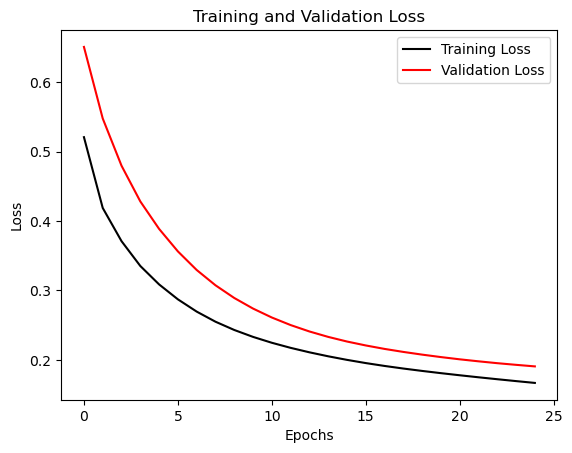

In [5]:
# Plot and label the training and validation loss values
plt.plot(list(range(len(history.history['loss']))), history.history['loss'], c='black', label='Training Loss')
plt.plot(list(range(len(history.history['val_loss']))), history.history['val_loss'], c='red', label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [6]:
predictions = funcs.make_predictions(model, datasets, params.forecast_horizon)

3135/3135 [==============================] - 8s 2ms/step


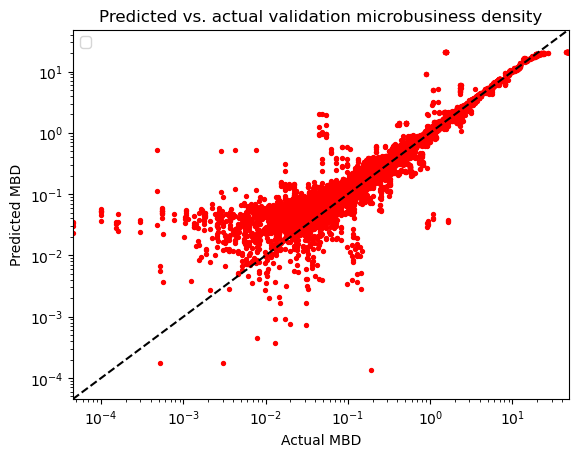

In [7]:
# Plot predicted vs actual MBD values for validation set
point_size = 8
plt.scatter(predictions['validation_targets'].flatten(), predictions['validation_predictions'].flatten(), s=point_size, c='red')

# Set common axis limits
data_pool = list(predictions['validation_targets'].flatten()) + list(predictions['validation_predictions'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual validation microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [8]:
# Split off the last three individual month's predictions
# this approximates the final private leaderboard scoring
index_3_validation_predictions = predictions['validation_predictions'][:,2]
index_4_validation_predictions = predictions['validation_predictions'][:,3]
index_5_validation_predictions = predictions['validation_predictions'][:,4]

index_3_validation_targets = predictions['validation_targets'][:,:,2].flatten()
index_4_validation_targets = predictions['validation_targets'][:,:,3].flatten()
index_5_validation_targets = predictions['validation_targets'][:,:,4].flatten()

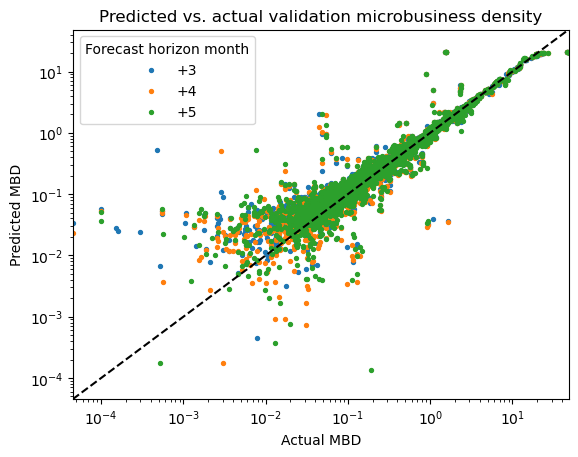

In [9]:
# Plot predicted vs actual MBD values for validation set by the forecast horizon index
point_size = 8
plt.scatter(index_3_validation_targets, index_3_validation_predictions, s=point_size, label='+3')
plt.scatter(index_4_validation_targets, index_4_validation_predictions, s=point_size, label='+4')
plt.scatter(index_5_validation_targets, index_5_validation_predictions, s=point_size, label='+5')

# Set common axis limits
data_pool = list(predictions['validation_targets'].flatten()) + list(predictions['validation_predictions'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual validation microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(title='Forecast horizon month', loc='best')
plt.show()

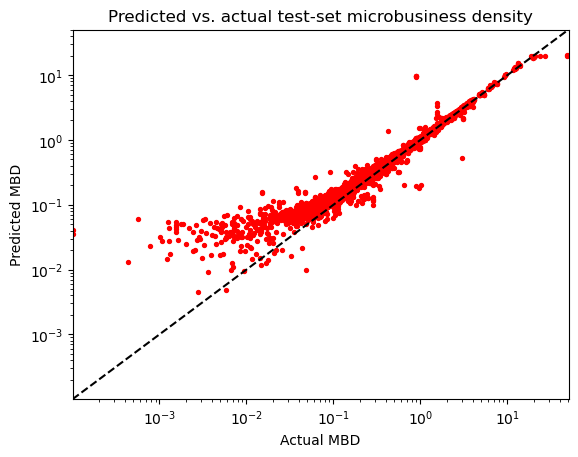

In [10]:
# Plot predicted vs actual MBD values for testing set
point_size = 8
plt.scatter(predictions['testing_targets'].flatten(), predictions['testing_predictions'].flatten(), s=point_size, c='red')

# Set common axis limits
data_pool = list(predictions['testing_targets'].flatten()) + list(predictions['testing_predictions'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual test-set microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.show()

In [11]:
# Split off the last three individual month's predictions
# this approximates the final private leaderboard scoring
index_3_testing_predictions = predictions['testing_predictions'][:,2]
index_4_testing_predictions = predictions['testing_predictions'][:,3]
index_5_testing_predictions = predictions['testing_predictions'][:,4]

index_3_testing_targets = predictions['testing_targets'][:,:,2].flatten()
index_4_testing_targets = predictions['testing_targets'][:,:,3].flatten()
index_5_testing_targets = predictions['testing_targets'][:,:,4].flatten()

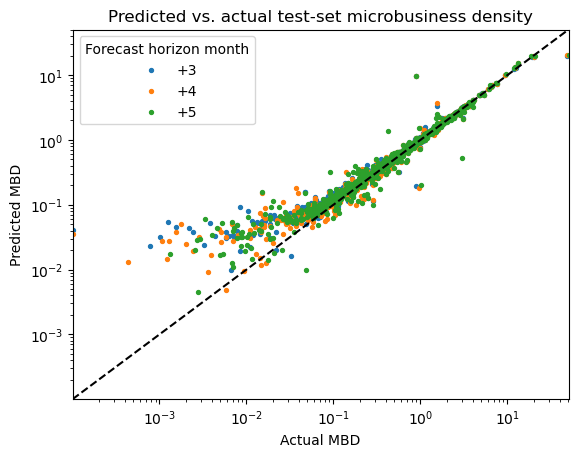

In [12]:
# Plot predicted vs actual MBD values for testing set by the forecast horizon index
point_size = 8
plt.scatter(index_3_testing_targets, index_3_testing_predictions, s=point_size, label='+3')
plt.scatter(index_4_testing_targets, index_4_testing_predictions, s=point_size, label='+4')
plt.scatter(index_5_testing_targets, index_5_testing_predictions, s=point_size, label='+5')

# Set common axis limits
data_pool = list(predictions['testing_targets'].flatten()) + list(predictions['testing_predictions'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual test-set microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(title='Forecast horizon month', loc='best')
plt.show()

OK, this all looks very fancy and surprisingly good. It's pretty obvious that we have some serious data leakage due to the sliding window used during our data parse. Not sure exactly what to do about that at the moment. For now, i'm going to accept it as a fact of life. This is maybe not so bad - we are not making a model that can predict MBD at an arbitrary time in the future from completely novel data - for the contest, we have all the data we ever will have, we just need to predict 5 month past the end of the dataset. I.e., re-using data that has been trained on already as input for the test set is maybe not so un-realistic. It might be a good idea to adjust our training, validation, testing split such that the targets for the test set have never been seen by the model at all. As it stands now, this is only true of the forecast +5 point. But, from the scatterplot above, it's pretty apparent that we don't do spectacularly worse on that timepoint anyways.

What I would really like to see before I call it a day is some comparison to the naive control. Let's see what we can come up with.

In [13]:
# Make naive, carry-forward predictions for the test set.

control_testing_prediction_values = datasets['testing'][:,:,-6,0]
GRU_testing_prediction_values = predictions['testing_predictions']
testing_prediction_targets = predictions['testing_targets'][:,0,:,0]

expanded_control_testing_prediction_values = []

for i in range(control_testing_prediction_values.shape[0]):
    prediction_value = control_testing_prediction_values[i][0]
    expanded_control_testing_prediction_values.append([prediction_value] * params.forecast_horizon)

expanded_control_testing_prediction_values = np.array(expanded_control_testing_prediction_values)


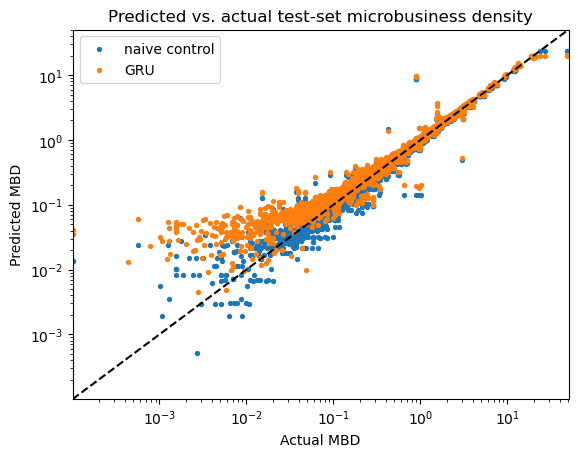

In [14]:
# Plot predicted vs actual MBD values for testing set by the forecast horizon index
point_size = 8
plt.scatter(testing_prediction_targets, expanded_control_testing_prediction_values, s=point_size, label='naive control')
plt.scatter(testing_prediction_targets, GRU_testing_prediction_values, s=point_size, label='GRU')

# Set common axis limits
data_pool = list(predictions['testing_targets'].flatten()) + list(predictions['testing_predictions'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual test-set microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(loc='best')
plt.show()

OK, we can work with this - not sure I would call it an improvement... but for no hyperparameter optimization, no architecture tuning and no exogenous data, I think we are doing ok... reality is, we are probably going to run out of time for this competition. Let's look at the SMAPE. The major consideration here is that we don't have a true leaderboard smape for prediction in the range [+3,+5] which is what we care about - let's look at just +1 to start. That way we can get a sense of if the control value even makes sense for our bootstrapped control distribution...

In [15]:
control_testing_prediction_values = datasets['testing'][:,:,-6,0]
GRU_testing_prediction_values = predictions['testing_predictions'][:,[0]]
testing_prediction_targets = predictions['testing_targets'][:,0,0]

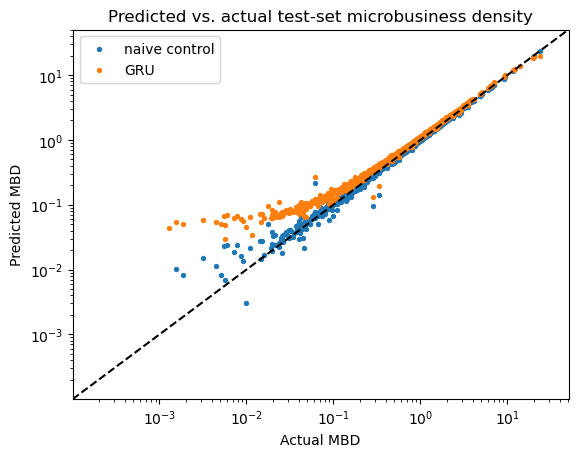

In [16]:
# Plot predicted vs actual MBD values for testing set by the forecast horizon index
point_size = 8
plt.scatter(testing_prediction_targets, control_testing_prediction_values, s=point_size, label='naive control')
plt.scatter(testing_prediction_targets, GRU_testing_prediction_values, s=point_size, label='GRU')

# Set common axis limits
data_pool = list(predictions['testing_targets'].flatten()) + list(predictions['testing_predictions'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual test-set microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [18]:
import functions.bootstrapping_functions as bootstrap_funcs
GRU_SMAPE_values = []

for actual, forecast in zip(testing_prediction_targets.flatten(), GRU_testing_prediction_values.flatten()):
    SMAPE_value = bootstrap_funcs.two_point_smape(actual, forecast)
    GRU_SMAPE_values.append(SMAPE_value)

GRU_SMAPE_score = (100/len(GRU_SMAPE_values)) * sum(GRU_SMAPE_values)

control_SMAPE_values = []

for actual, forecast in zip(testing_prediction_targets.flatten(), control_testing_prediction_values.flatten()):
    SMAPE_value = bootstrap_funcs.two_point_smape(actual, forecast)
    control_SMAPE_values.append(SMAPE_value)

control_SMAPE_score = (100/len(control_SMAPE_values)) * sum(control_SMAPE_values)

print(f'GRU SMAPE score: {GRU_SMAPE_score:.3f}')
print(f'Control SMAPE score: {control_SMAPE_score:.3f}')

GRU SMAPE score: 21.824
Control SMAPE score: 4.888


OK, so not winning - and pretty clear when and why. At low MBD values, the model tends to over estimate. Just for fun and encouragemnt, let's see how we do with training data?

In [80]:
control_training_prediction_values = datasets['training'][:,:,-6,0].flatten()
GRU_training_prediction_values = predictions['training_predictions'][:,[0]].flatten()
training_prediction_targets = predictions['training_targets'][:,:,[0]].flatten()

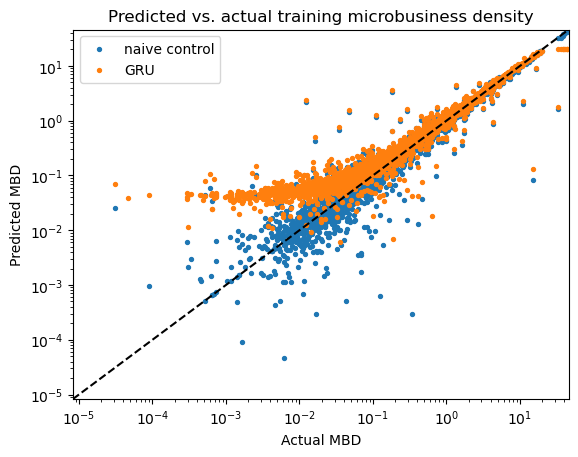

In [87]:
point_size = 8
plt.scatter(training_prediction_targets, control_training_prediction_values, s=point_size, label='naive control')
plt.scatter(training_prediction_targets, GRU_training_prediction_values, s=point_size, label='GRU')

# Set common axis limits
data_pool = list(predictions['training_targets'].flatten()) + list(predictions['training_predictions'].flatten())
trimmed_data_pool = [i for i in data_pool if i > 0]

plot_max = max(trimmed_data_pool)
plot_min = min(trimmed_data_pool)

plt.xlim([plot_min, plot_max])
plt.ylim([plot_min, plot_max])

# Set log10 scales
plt.xscale('log')
plt.yscale('log')

# Add y=x line
plt.axline((plot_min, plot_min), (plot_max, plot_max), color='black', linestyle='dashed')

# Add in a title and axes labels
plt.title('Predicted vs. actual training microbusiness density')
plt.xlabel('Actual MBD')
plt.ylabel('Predicted MBD')
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [88]:
GRU_SMAPE_values = []

for actual, forecast in zip(training_prediction_targets.flatten(), GRU_training_prediction_values.flatten()):
    SMAPE_value = bootstrap_funcs.two_point_smape(actual, forecast)
    GRU_SMAPE_values.append(SMAPE_value)

GRU_SMAPE_score = (100/len(GRU_SMAPE_values)) * sum(GRU_SMAPE_values)

control_SMAPE_values = []

for actual, forecast in zip(training_prediction_targets.flatten(), control_training_prediction_values.flatten()):
    SMAPE_value = bootstrap_funcs.two_point_smape(actual, forecast)
    control_SMAPE_values.append(SMAPE_value)

control_SMAPE_score = (100/len(control_SMAPE_values)) * sum(control_SMAPE_values)

print(f'GRU SMAPE score: {GRU_SMAPE_score:.3f}')
print(f'Control SMAPE score: {control_SMAPE_score:.3f}')

GRU SMAPE score: 20.599
Control SMAPE score: 5.943


Yeah, nope - not better. Ok, so obvious plan is - we need:

1. Confidence in/improvement to our testing data set.
2. A good few rounds of GRU optimization
3. More features!